# Assignment: Multi-Class Classification 

Dataset: Covertype (UCI) — predict forest cover type.

Model: **Random Forest**

Explainability: **SHAP**

This notebook includes data loading, preprocessing (multicollinearity check + scaling),
training, and SHAP-based interpretation with plots.

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import shap
import warnings
warnings.filterwarnings('ignore')

print('Libraries imported')

Libraries imported


In [4]:
# Load Covertype dataset
cov =fetch_covtype()
X = pd.DataFrame(cov.data, columns=cov.feature_names)
y = cov.target
print('Shape X:', X.shape)
print('Unique classes:', np.unique(y))
X.head()

Shape X: (581012, 54)
Unique classes: [1 2 3 4 5 6 7]


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploratory Data Analysis
- Check basic stats and class balance


In [5]:
display(X.describe())
print('\nClass distribution:')
print(pd.Series(y).value_counts())

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39
count,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,...,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000,581012.000000
mean,2959.365301,155.656807,14.103704,269.428217,46.418855,2350.146611,212.146049,223.318716,142.528263,1980.291226,...,0.044175,0.090392,0.077716,0.002773,0.003255,0.000205,0.000513,0.026803,0.023762,0.015060
std,279.984734,111.913721,7.488242,212.549356,58.295232,1559.254870,26.769889,19.768697,38.274529,1324.195210,...,0.205483,0.286743,0.267725,0.052584,0.056957,0.014310,0.022641,0.161508,0.152307,0.121791
min,1859.000000,0.000000,0.000000,0.000000,-173.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2809.000000,58.000000,9.000000,108.000000,7.000000,1106.000000,198.000000,213.000000,119.000000,1024.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2996.000000,127.000000,13.000000,218.000000,30.000000,1997.000000,218.000000,226.000000,143.000000,1710.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3163.000000,260.000000,18.000000,384.000000,69.000000,3328.000000,231.000000,237.000000,168.000000,2550.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3858.000000,360.000000,66.000000,1397.000000,601.000000,7117.000000,254.000000,254.000000,254.000000,7173.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000



Class distribution:
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64


## Preprocessing
1. Check multicollinearity (correlation / VIF)
2. Scale features using StandardScaler


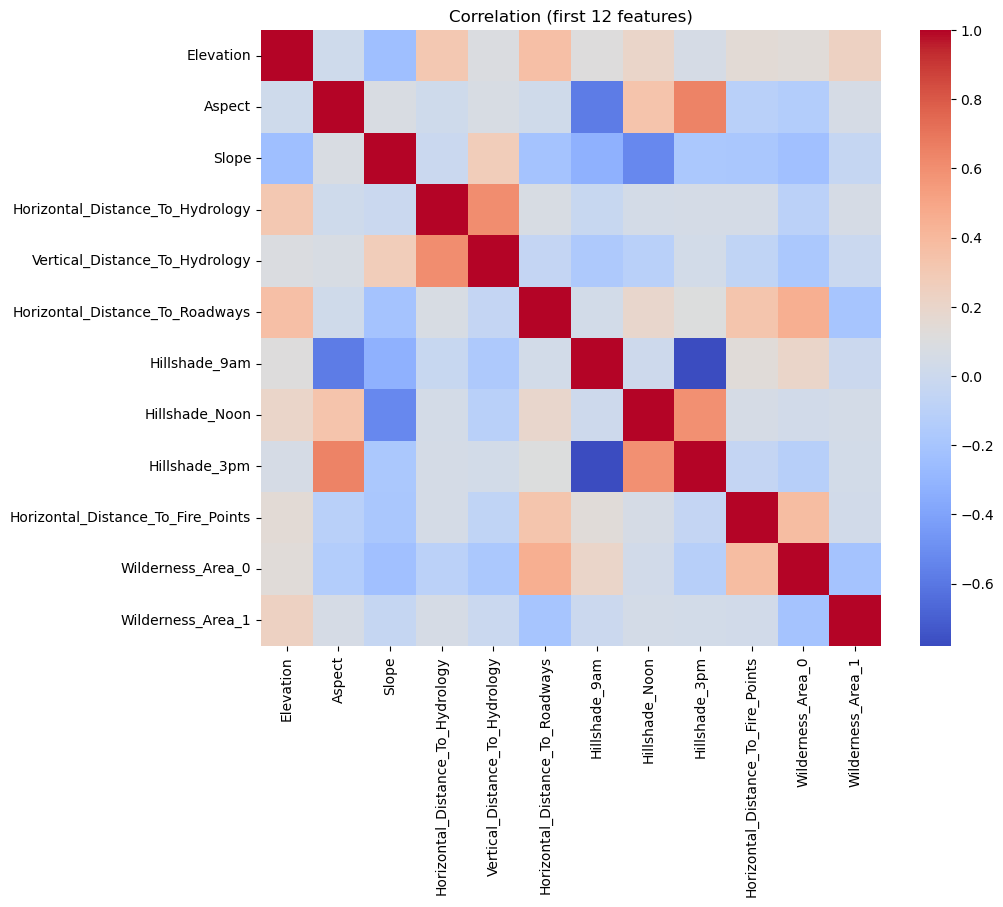

In [6]:
# Correlation heatmap for a subset (plotting all features may be heavy)
subset = X.iloc[:, :12]  # first 12 features to visualize
plt.figure(figsize=(10,8))
sns.heatmap(subset.corr(), annot=False, cmap='coolwarm')
plt.title('Correlation (first 12 features)')
plt.show()

In [7]:
# Calculate VIF for numeric features
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF expects no constant and numeric array
X_numeric = X.select_dtypes(include=[np.number])
# To speed up, we compute VIF on first 20 numeric features if there are many
vif_features = X_numeric.columns[:20]
X_vif = X_numeric[vif_features].copy()

vif_data = pd.DataFrame()
vif_data['feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data.sort_values('VIF', ascending=False).head(20)

,feature,VIF
10,Wilderness_Area_0,1961.536135
12,Wilderness_Area_2,1913.028387
13,Wilderness_Area_3,271.904966
11,Wilderness_Area_1,228.867111
8,Hillshade_3pm,147.543887
6,Hillshade_9am,106.941246
7,Hillshade_Noon,39.255760
2,Slope,7.041752
0,Elevation,2.462247
1,Aspect,1.873571


In [8]:
# Scale features and split
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

Train shape: (464809, 54) Test shape: (116203, 54)


## Train Random Forest (baseline)

In [9]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
# Predictions and evaluation
y_pred = rf.predict(X_test)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('\nClassification report:')
print(classification_report(y_test, y_pred))

Accuracy: 0.9551302462070687

Classification report:
              precision    recall  f1-score   support

           1       0.97      0.94      0.95     42557
           2       0.95      0.97      0.96     56500
           3       0.94      0.96      0.95      7121
           4       0.91      0.85      0.88       526
           5       0.94      0.77      0.85      1995
           6       0.93      0.90      0.92      3489
           7       0.97      0.96      0.97      4015

    accuracy                           0.96    116203
   macro avg       0.95      0.91      0.93    116203
weighted avg       0.96      0.96      0.95    116203



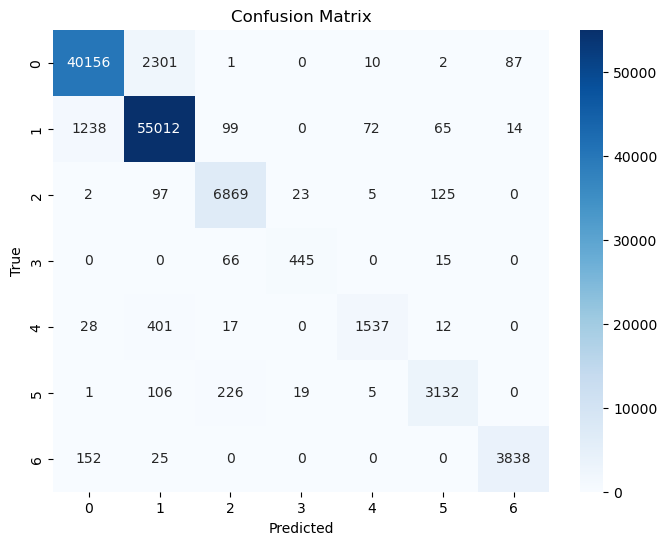

In [10]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

## SHAP Explainability

In [11]:
explainer = shap.Explainer(rf,X_train,feature_perturbation="interventional")
shap_values = explainer(X_test[:1000],approximate=True)

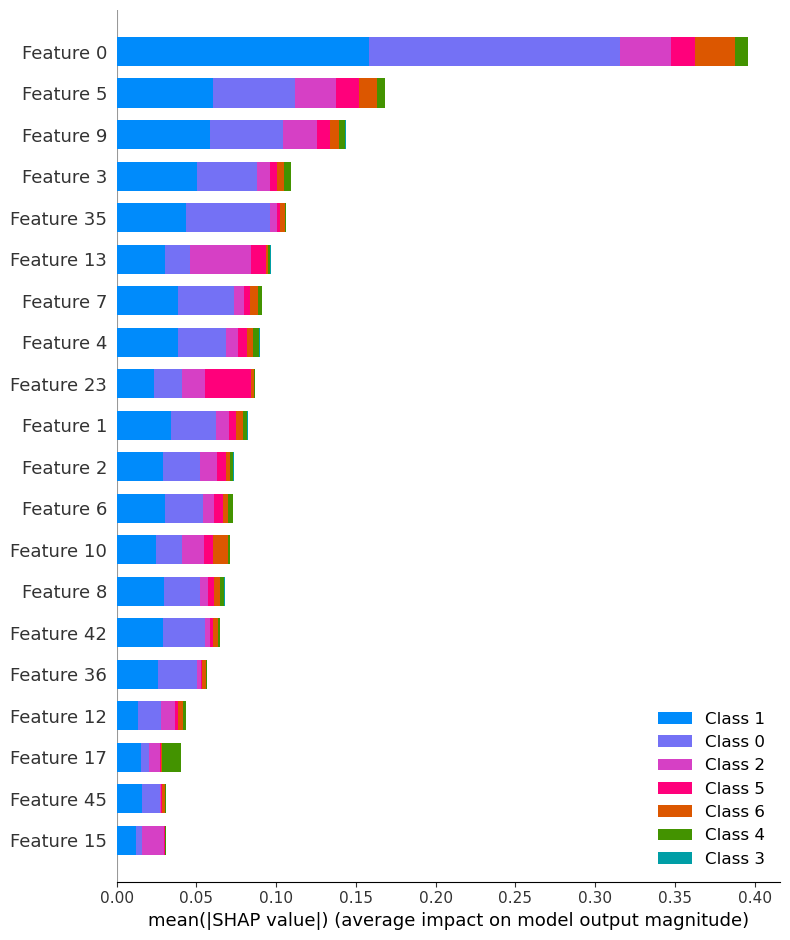

In [12]:
shap.summary_plot(shap_values,X_test[:1000])


SHAP Summary for Class 0


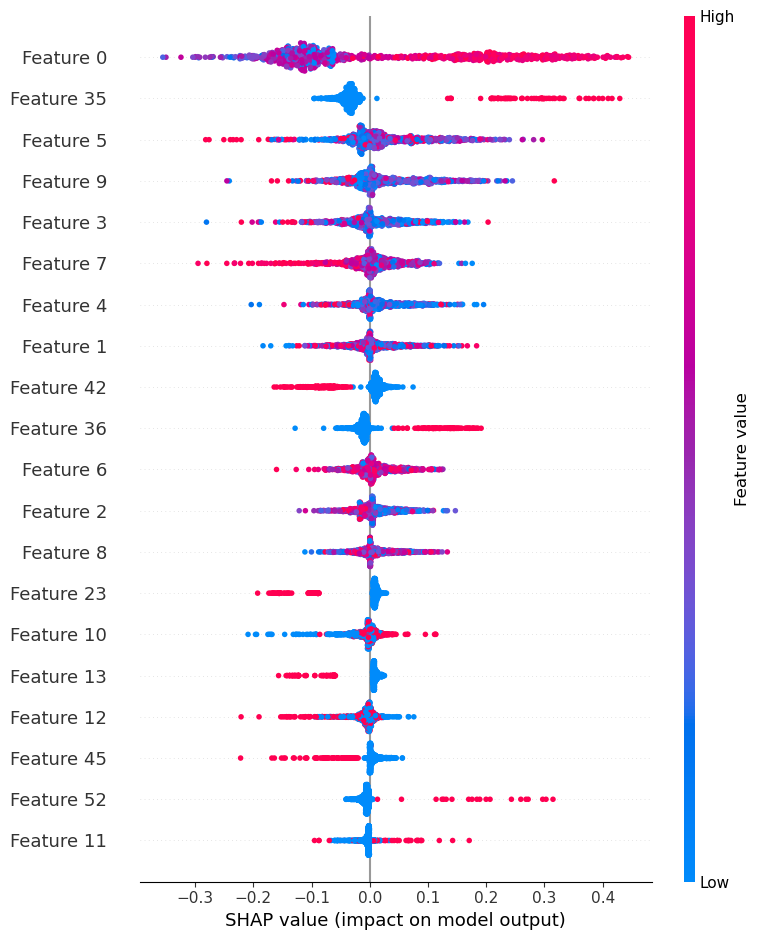


SHAP Summary for Class 1


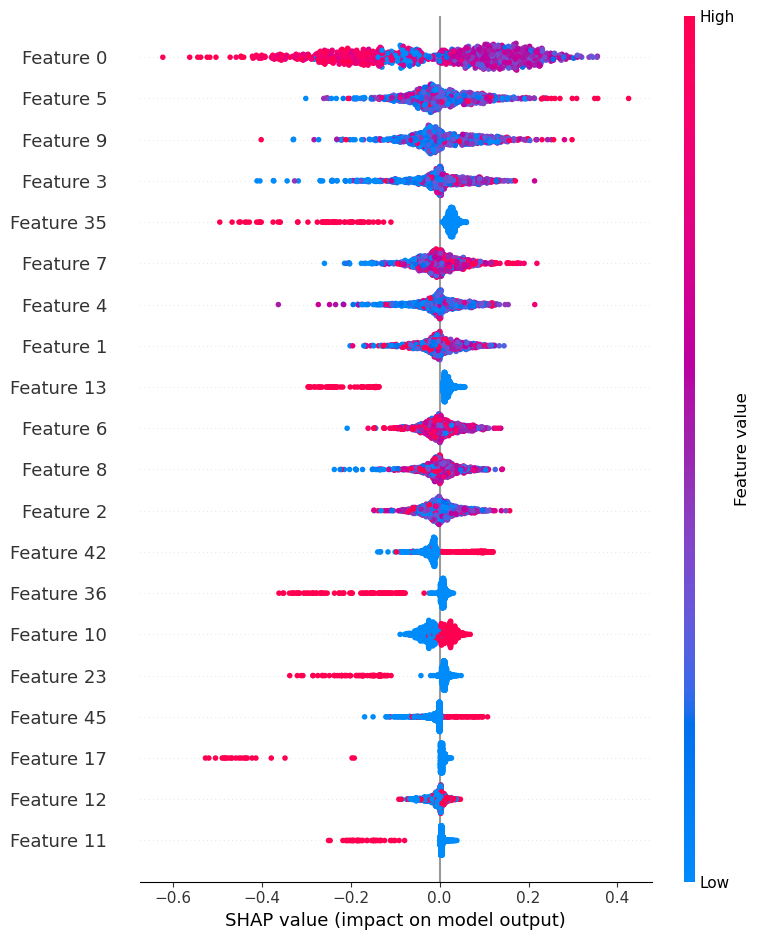


SHAP Summary for Class 2


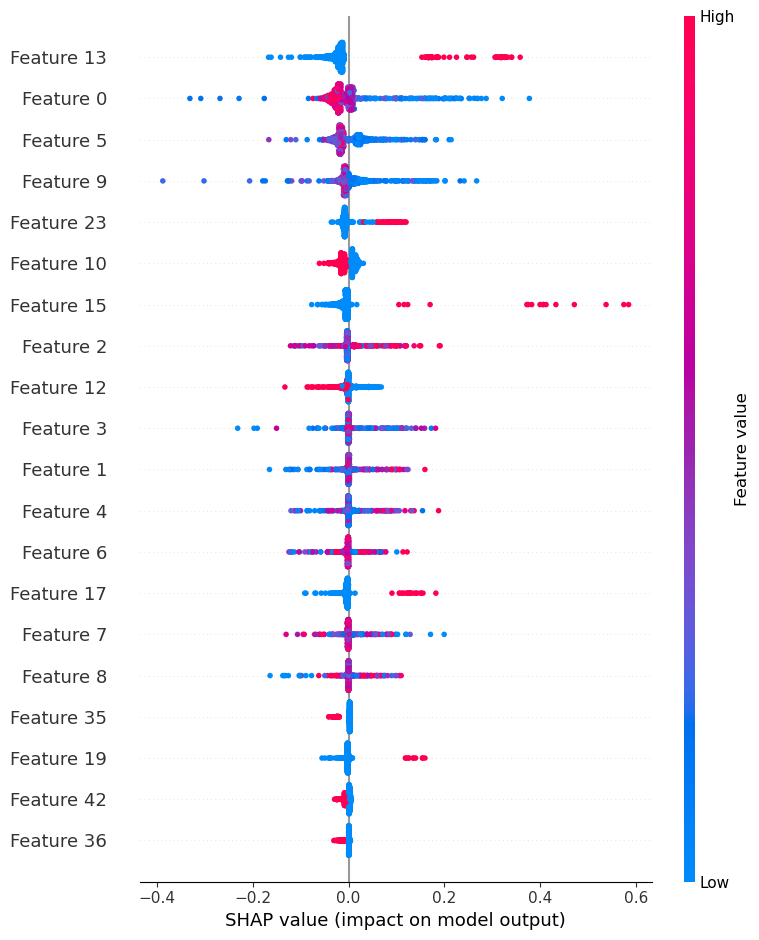


SHAP Summary for Class 3


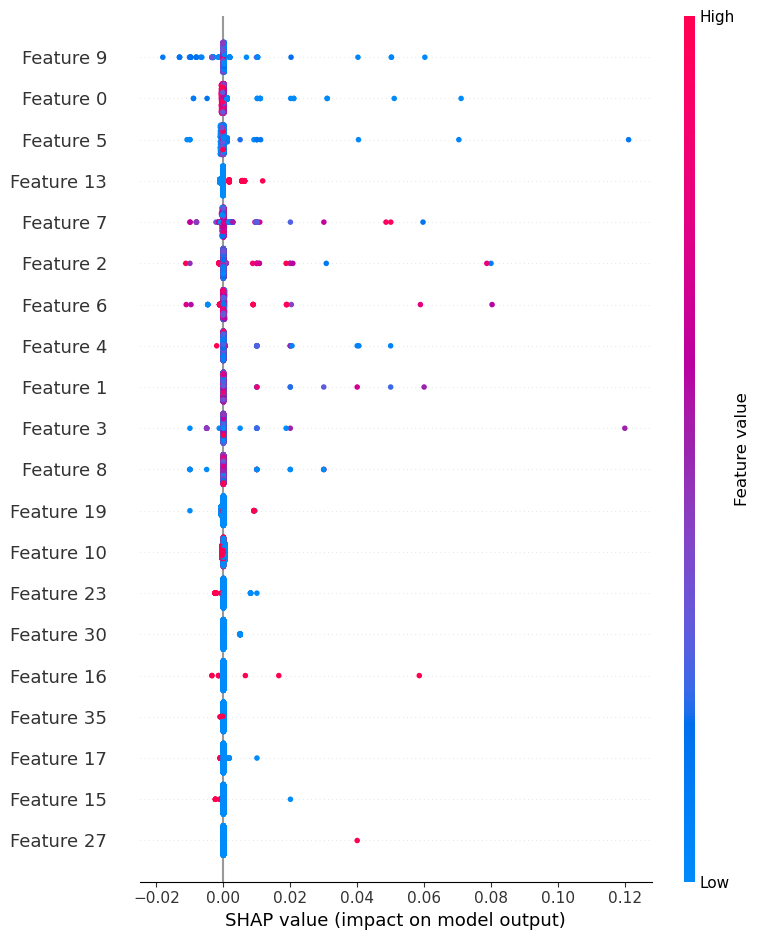


SHAP Summary for Class 4


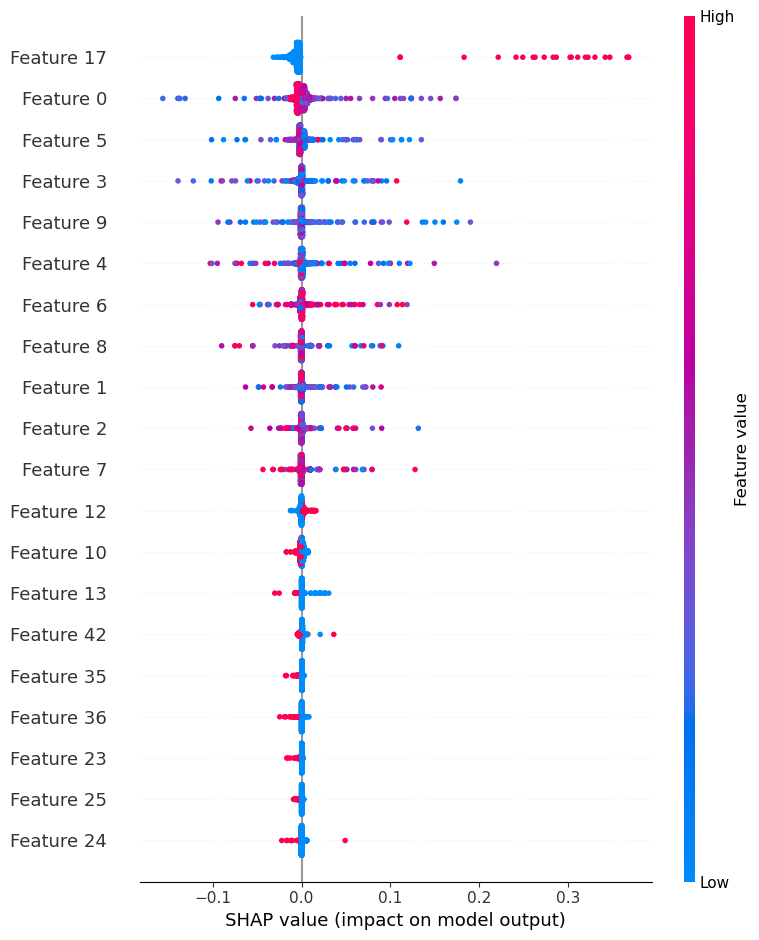


SHAP Summary for Class 5


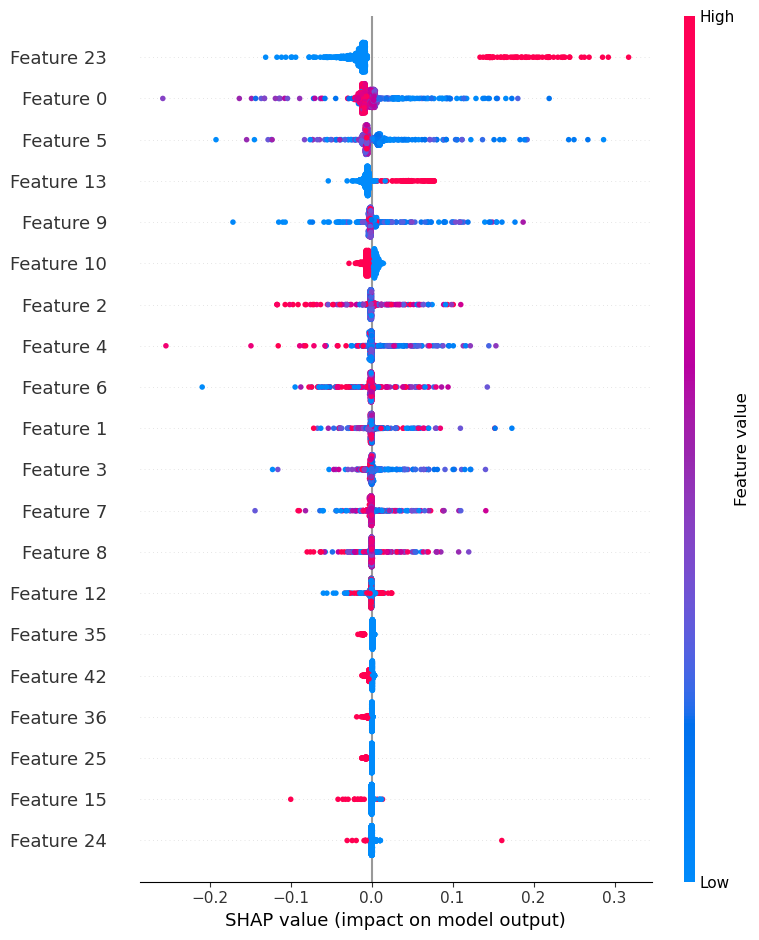


SHAP Summary for Class 6


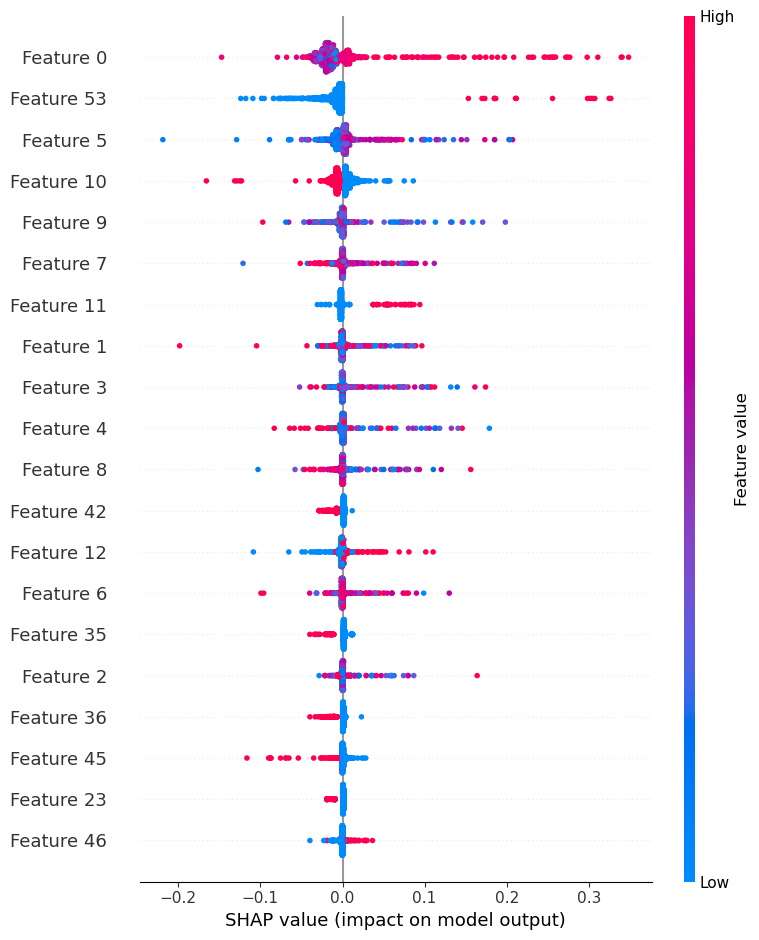

In [38]:
for class_idx in range(7):
    print(f"\nSHAP Summary for Class {class_idx}")
    shap.summary_plot(shap_values[..., class_idx], X_test[:1000])

## CONCLUSION:

* ACCURACY: high overall accuracy
* CLASSIFICATION REPORT: Precision, recall, and F1-score were strong for most classes, though some classes (e.g., 4 and 5) may have shown lower performance due to class imbalance or feature overlap.

The model performs well overall, with strong generalization. However, certain classes are harder to distinguish, likely due to similar feature distributions or fewer training examples.

### FEATURE IMPORTANCE

we used two methods to assess feature importance:
RandomForest feature importance: Based on gini impurity reduction.
SHAP Summary PLot: Based on average absolute SHAP values.

### INTERPRETATION:

Elevation and hydrology-related features are the most influential in predicting forest cover types. This aligns with ecological expectations, as vegetation types are strongly influenced by altitude and water availability.

#### SHAP Summary Plots(Per Class) 

We generated SHAP summary plots for individual classes to understand which features drive predictions for each forest type.

##### Interpretation:

For example, class 2 was heavily influenced by high elevation and low horizontal distance to hydrology, indicating that this forest type is typically found in high-altitude, water-adjacent areas. In contrast, class 5 showed strong influence from soil type and hillshade features.